# Tutorial 5 (SimPy)

## Question 1

a. The idea is to monitor the *number of customers in the system* (call this the *state*).
At any *event* (customer arrival, begin service, end service), we need to know if this changes the number of customers in the system, and update the state accordingly.
1. Use a class variable **n** in the **Arrival** class to keep track of exactly how many customers there are in the system.
2. Set up a new monitor called **numbermon** in a similar way to **delaymon**.
3. Modify the **run** method (PEM) within the **Arrival** class so that whenever an event occurs (customer arrival, begin service, end service) we update the state (class variable **Arrival.n**) and then the **numbermon** monitor will **observe** the new value of the state.
4. Modify the **model** function to return both **W** and **L** in a tuple where
$\verb|L = G.numbermon.timeAverage()|$
5. Add a new list **allL** to the simulation experiment in a similar way to **allW**.

Test your simulation model with $c=1$, $\lambda=3$ and $\mu=5$.
- For each performance measure ($W$ and $L$) produce both a point estimate and a 95\% confidence interval from 50 replications. 
- *Compare* your results to the expected values of $W$ and $L$ for an M/M/1 queueing system.
- *Determine* whether *Little's Law* appears to hold in your simulation results by forming a confidence interval for $\lambda_{eff}$, i.e., each replication will give one estimate of $\lambda_{eff}=\frac{L}{W}$.

b. Adding to part (a), we wish monitor the *proportion of time the server is busy*.
- Set up a new monitor called **busymon** in a similar way to **delaymon** and **numbermon**.
- Modify the **run** method (PEM) within the **Arrival** class so that whenever the state **Arrival.n** is updated, the **busymon** monitor will **observe* a \fbox{1} if there are any customers in the system and a \fbox{0} if there are no customers in the system.
- Modify the **model** function to return a tuple $(W,L,B)$ where
$\verb|B = G.busymon.timeAverage()|$
- Add a new list **allB** to the simulation experiment in a similar way to **allL** and **allW**.
- Test your simulation model as in part (a).

In [1]:
"""(q4.py) M/M/c queueing system with several monitors and multiple replications"""

from SimPy.Simulation import *
import random
import numpy
import math

In [2]:
def conf(L):
    """confidence interval"""
    lower = numpy.mean(L) - 1.96*numpy.std(L)/math.sqrt(len(L))
    upper = numpy.mean(L) + 1.96*numpy.std(L)/math.sqrt(len(L))
    return lower, upper

In [3]:
class Source(Process):
    """generate random arrivals"""
    def run(self, N, lamb, mu):
        for i in range(N):
            a = Arrival(str(i))
            activate(a, a.run(mu))
            t = random.expovariate(lamb)
            yield hold, self, t

In [4]:
class Arrival(Process):
    """an arrival"""
    n = 0  # class variable (number in system)

    def run(self, mu):
        # Event: arrival
        Arrival.n += 1   # number in system
        arrivetime = now()
        G.numbermon.observe(Arrival.n)
        if (Arrival.n>0):
            G.busymon.observe(1)
        else:
            G.busymon.observe(0)

        yield request, self, G.server
        # ... waiting in queue for server to be empty (delay) ...
      
        # Event: service begins
        t = random.expovariate(mu)
      
        yield hold, self, t
        # ... now being served (activity) ...
      
        # Event: service ends
        yield release, self, G.server # let go of server (takes no simulation time)
        Arrival.n -= 1
        G.numbermon.observe(Arrival.n)
        if (Arrival.n>0):
            G.busymon.observe(1)
        else:
            G.busymon.observe(0)
        delay = now()-arrivetime
        G.delaymon.observe(delay)

In [5]:
class G:
    server = 'dummy'
    delaymon = 'Monitor'
    numbermon = 'Monitor'
    busymon = 'Monitor'

In [6]:
def model(c, N, lamb, mu, maxtime, rvseed):
    # setup
    initialize()
    random.seed(rvseed)
    G.server = Resource(c)
    G.delaymon = Monitor()
    G.numbermon = Monitor()
    G.busymon = Monitor()
    
    Arrival.n = 0
   
    # simulate
    s = Source('Source')
    activate(s, s.run(N, lamb, mu))
    simulate(until=maxtime)

    # gather performance measures
    W = G.delaymon.mean()
    L = G.numbermon.timeAverage()
    B = G.busymon.timeAverage()
    return W, L, B

In [7]:
## Experiment ----------------
allW = []
allL = []
allB = []
allLambdaEffective = []
for k in range(50):
    seed = 123*k
    result = model(c=1, N=10000, lamb=3, mu=5, maxtime=2000000, rvseed=seed)
    allW.append(result[0])
    allL.append(result[1])
    allB.append(result[2])
    allLambdaEffective.append(result[1]/result[0])

In [8]:
print("Estimate of W:", numpy.mean(allW))
print("Conf int of W:", conf(allW))
print("Estimate of L:", numpy.mean(allL))
print("Conf int of L:", conf(allL))
print("Estimate of B:", numpy.mean(allB))
print("Conf int of B:", conf(allB))
print("Estimate of LambdaEffective:", numpy.mean(allLambdaEffective))
print("Conf int of LambdaEffective:", conf(allLambdaEffective))

Estimate of W: 0.5002552383402216
Conf int of W: (0.49503594147899854, 0.5054745352014446)
Estimate of L: 1.5019964292934942
Conf int of L: (1.4841970173280463, 1.519795841258942)
Estimate of B: 0.5998344143844396
Conf int of B: (0.5977099946713437, 0.6019588340975356)
Estimate of LambdaEffective: 3.002010391868243
Conf int of LambdaEffective: (2.993370764645074, 3.010650019091412)


Comments:
- For an M/M/1 queueing system with $\lambda=3$ and $\mu=5$ we expect $\rho=\tfrac{\lambda}{\mu}=0.6$, $L=\frac{\rho}{1-\rho}=1.5$ and $W=\tfrac{L}{\lambda}=0.5$.  Clearly all three of these values are inside their respective confidence intervals (the expected value of **B** is $\rho$).
- Little's Law appears to hold as $\lambda=3$ is inside the confidence interval for $\lambda_{eff}$.

## Question 2

The module **matplotlib** is a Python 2D plotting library which produces publication quality figures.  Run the follow fragment of Python code and explain roughly what each of the commands appear to do.

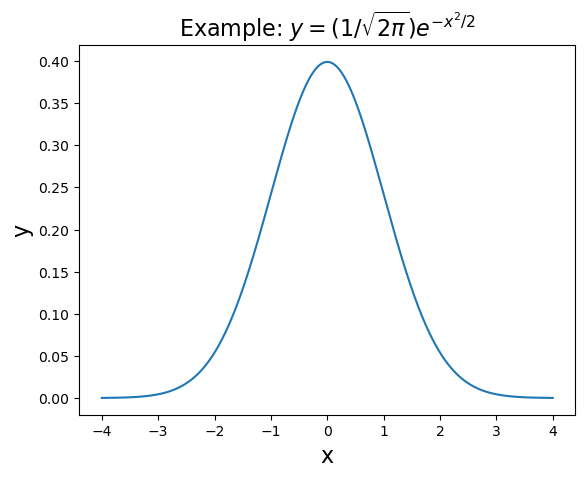

In [9]:
import numpy
import matplotlib.pyplot as pl
x = numpy.linspace(-4,4,1000)
y = (1/numpy.sqrt(2*numpy.pi))*numpy.exp(-0.5*x**2)
pl.clf()
pl.plot(x,y)
pl.title("Example: $y=(1/\sqrt{2\pi})e^{-x^2/2}$", fontsize=16)
pl.xlabel("x", fontsize=16)
pl.ylabel("y", fontsize=16)
pl.axis("tight")
pl.savefig("myfig.png")